<a href="https://colab.research.google.com/github/Jacada6/Prusa-Firmware/blob/master/CHEMTaskAI_e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Copy the dataframe from drive 
!cp '/content/gdrive/MyDrive/Projects/Mama AI/hERG_dataset.csv' /content/

# Unmount the gdrive
drive.flush_and_unmount()

Mounted at /content/gdrive


In [2]:
# Install RDKit and SHAP
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import sys
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import shap
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from rdkit import DataStructs
from rdkit.Chem import Descriptors

from statistics import mean, stdev

import matplotlib.pyplot as plt

# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=1000, edgeitems=10)

In [4]:
df = pd.read_csv("hERG_dataset.csv")

In [5]:
df["smiles"].isnull().sum() #check whether include null or not

0

In [6]:
#df['activity'].value_counts()[0]
#df['activity'].value_counts()[1]
print(f"Toxic compounds {df['activity'].value_counts()[1]} and Non-toxic compounds {df['activity'].value_counts()[0]}")

Toxic compounds 2164 and Non-toxic compounds 5990


In [7]:
df["mols"] = df["smiles"].apply(lambda x: Chem.MolFromSmiles(x)) #creating moles
df["fingerprints"] = df["mols"].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024)) #assigning fingerprints to the mols

In [107]:
df

,smiles,activity,mols,fingerprints,bi
0,COc1ccc([C@@H](O)C[C@H]2c3cc(OC)c(OC)cc3CCN2C)cc1,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70740>,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",
1,Cc1nnc(N2CC[C@@H](F)C2)c2nn(-c3ccc(OCC(F)(F)F)...,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70820>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",
2,O=c1n(Cc2ccccc2)c2sc3c(c2c2ncnn12)CCN(CC1CCOCC...,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a707b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",
3,COCCCc1cc(CN(C(=O)[C@H]2CNCC[C@@H]2c2ccc(OCCOc...,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70890>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",
4,CC1(C)C2=C3C=C4C5=[N+](CCC4OC3CCN2c2ccc(CC(=O)...,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70900>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",
...,...,...,...,...,...
8149,C#C[C@]1(OC(C)=O)CC[C@H]2[C@@H]3CCC4=C/C(=N/O)...,0,<rdkit.Chem.rdchem.Mol object at 0x7ff787976cf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",
8150,CC1=C(C=C/C(C)=C/C=C/C(C)=C/C(=O)Oc2c(C)c(C)c3...,0,<rdkit.Chem.rdchem.Mol object at 0x7ff787976d60>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",
8151,COC(=O)CCC[N+](C)(C)C,0,<rdkit.Chem.rdchem.Mol object at 0x7ff787976dd0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",
8152,C[N+]1(CC2COC(c3ccccc3)(C3CCCCC3)O2)CCCCC1,0,<rdkit.Chem.rdchem.Mol object at 0x7ff787976e40>,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",


In [131]:
dict_temp = {}
df["bi"] = ""
df["bi"] = df["bi"].apply(lambda x: dict_temp)

In [164]:
df[["mols", "bi"]].apply(lambda x: x.index) #assigning fingerprints to the mols

,mols,bi
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
8149,8149,8149
8150,8150,8150
8151,8151,8151
8152,8152,8152


In [152]:
df[["mols", "bi"]]

,mols,bi
0,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70740>,{}
1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70820>,{}
2,<rdkit.Chem.rdchem.Mol object at 0x7ff787a707b0>,{}
3,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70890>,{}
4,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70900>,{}
...,...,...
8149,<rdkit.Chem.rdchem.Mol object at 0x7ff787976cf0>,{}
8150,<rdkit.Chem.rdchem.Mol object at 0x7ff787976d60>,{}
8151,<rdkit.Chem.rdchem.Mol object at 0x7ff787976dd0>,{}
8152,<rdkit.Chem.rdchem.Mol object at 0x7ff787976e40>,{}


In [154]:
df

,smiles,activity,mols,fingerprints,bi
0,COc1ccc([C@@H](O)C[C@H]2c3cc(OC)c(OC)cc3CCN2C)cc1,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70740>,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",{}
1,Cc1nnc(N2CC[C@@H](F)C2)c2nn(-c3ccc(OCC(F)(F)F)...,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70820>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",{}
2,O=c1n(Cc2ccccc2)c2sc3c(c2c2ncnn12)CCN(CC1CCOCC...,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a707b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",{}
3,COCCCc1cc(CN(C(=O)[C@H]2CNCC[C@@H]2c2ccc(OCCOc...,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70890>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",{}
4,CC1(C)C2=C3C=C4C5=[N+](CCC4OC3CCN2c2ccc(CC(=O)...,1,<rdkit.Chem.rdchem.Mol object at 0x7ff787a70900>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",{}
...,...,...,...,...,...
8149,C#C[C@]1(OC(C)=O)CC[C@H]2[C@@H]3CCC4=C/C(=N/O)...,0,<rdkit.Chem.rdchem.Mol object at 0x7ff787976cf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",{}
8150,CC1=C(C=C/C(C)=C/C=C/C(C)=C/C(=O)Oc2c(C)c(C)c3...,0,<rdkit.Chem.rdchem.Mol object at 0x7ff787976d60>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",{}
8151,COC(=O)CCC[N+](C)(C)C,0,<rdkit.Chem.rdchem.Mol object at 0x7ff787976dd0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",{}
8152,C[N+]1(CC2COC(c3ccccc3)(C3CCCCC3)O2)CCCCC1,0,<rdkit.Chem.rdchem.Mol object at 0x7ff787976e40>,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",{}


In [165]:
dict_temp = {}
df["bi"] = ""
df["bi"] = df["bi"].apply(lambda x: dict_temp)
df["fingerprints"] = df[["mols", "bi"]].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024, bitInfo=df["bi"][x.index])) #assigning fingerprints to the mols


df.loc[0]["smiles"]

ArgumentError: ignored

In [95]:
#CREATE A NEW COLUMN FOR BITINFOS

# bi = {}
# fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(df["smiles"][0]), 2, nBits=1024, bitInfo=bi)

AttributeError: ignored

In [8]:
X = df["fingerprints"]
y = df["activity"]

In [9]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
def get_metrics(fold, model, test, pred, test_prob):
  d = {
    "model": model,
    "fold": fold,
    "c_report": classification_report(test, pred),
    "accuracy": accuracy_score(test, pred),
    "sensivity": recall_score(test, pred),
    "specificity": recall_score(test, pred, pos_label=0),
    "auc": roc_auc_score(test, test_prob),
  }
  return d

In [11]:
svm = SVC(kernel="linear", probability=True)
dt = DecisionTreeClassifier()
nn = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000)

skf = StratifiedKFold(n_splits=5)

model_metrics = pd.DataFrame(columns=["model", "fold", "c_report", "accuracy", "sensivity", "specificity", "auc"])

for fold, (train_index, test_index) in enumerate(skf.split(df_X_train, df_y_train)):
  print(f"Fold {fold}")
  X_train_fold = df_X_train.iloc[train_index].tolist()
  y_train_fold = df_y_train.iloc[train_index].tolist()
  X_test_fold = df_X_train.iloc[test_index].tolist()
  y_test_fold = df_y_train.iloc[test_index].tolist()

  # SVM
  svm.fit(X_train_fold, y_train_fold)  
  y_pred_fold = svm.predict(X_test_fold)
  test_prob_fold = svm.predict_proba(X_test_fold)[:, 1]
  model_metrics = model_metrics.append(get_metrics(fold, "SVM", y_test_fold, y_pred_fold, test_prob_fold), ignore_index=True)

  # DT
  dt.fit(X_train_fold, y_train_fold)
  y_pred_fold = dt.predict(X_test_fold)
  test_prob_fold = dt.predict_proba(X_test_fold)[:, 1]
  model_metrics = model_metrics.append(get_metrics(fold, "DT", y_test_fold, y_pred_fold, test_prob_fold), ignore_index=True)

  # NN
  nn.fit(X_train_fold, y_train_fold)  
  y_pred_fold = nn.predict(X_test_fold)
  test_prob_fold = nn.predict_proba(X_test_fold)[:, 1]
  model_metrics = model_metrics.append(get_metrics(fold, "NN", y_test_fold, y_pred_fold, test_prob_fold), ignore_index=True)

Fold 0
Fold 1


In [12]:
model_metrics

,model,fold,c_report,accuracy,sensivity,specificity,auc
0,SVM,0,precision recall f1-score ...,0.819129,0.668591,0.873539,0.856032
1,DT,0,precision recall f1-score ...,0.800123,0.654734,0.852671,0.754471
2,NN,0,precision recall f1-score ...,0.843348,0.693995,0.897329,0.865866
3,SVM,1,precision recall f1-score ...,0.815701,0.655491,0.873539,0.846108
4,DT,1,precision recall f1-score ...,0.812634,0.646243,0.872705,0.761996
5,NN,1,precision recall f1-score ...,0.835940,0.704046,0.883556,0.856257


In [13]:
print(model_metrics.c_report[0])

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2396
           1       0.66      0.67      0.66       866

    accuracy                           0.82      3262
   macro avg       0.77      0.77      0.77      3262
weighted avg       0.82      0.82      0.82      3262



In [15]:
# X_train = np.array(df_X_train.tolist()) #converting fingerprints train data to list first and then np array
# X_test = np.array(df_X_test.tolist()) #converting fingerprints test data to list first and then np array
# y_train = np.array(df_y_train.tolist()) #converting activities train data to list first and then np array
# y_test = np.array(df_y_test.tolist()) #converting activities test data to list first and then np array

X_train = df_X_train.tolist() #converting fingerprints train data to list
X_test = df_X_test.tolist() #converting fingerprints test data to list
y_train = df_y_train.tolist() #converting activities train data to list
y_test = df_y_test.tolist() #converting activities test data to list

In [16]:
# Train a SVM model
svm = SVC(kernel="linear", probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [17]:
y_pred_svm = svm.predict(X_test)
test_prob_svm = svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, test_prob_svm)

In [18]:
# Train the Decision Tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [19]:
y_pred_dt = dt.predict(X_test)
test_prob_dt = dt.predict_proba(X_test)[:, 1]
auc_dt = roc_auc_score(y_test, test_prob_dt)

In [20]:
# Train the Neural Network model
nn = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000)
nn.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)

In [21]:
y_pred_nn = nn.predict(X_test)
test_prob_nn = nn.predict_proba(X_test)[:, 1]
auc_nn = roc_auc_score(y_test, test_prob_nn)

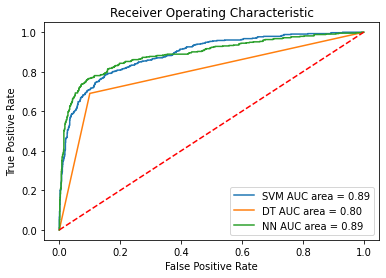

In [22]:
fig, ax = plt.subplots()

# Compute False postive rate and True positive rate
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, test_prob_svm)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, test_prob_dt)
fpr_nn, tpr_nn, thresholds_nn = metrics.roc_curve(y_test, test_prob_nn)

# Plot the computed values
ax.plot(fpr_svm, tpr_svm, label=(f"SVM AUC area = {auc_svm:.2f}"))
ax.plot(fpr_dt, tpr_dt, label=(f"DT AUC area = {auc_dt:.2f}"))
ax.plot(fpr_nn, tpr_nn, label=(f"NN AUC area = {auc_nn:.2f}"))

# Custom settings for the plot
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic")
ax.legend(loc="lower right")

In [36]:
print("------------ Stratified 5-fold Cross Validation ------------")
print("SVM: ")
print(f'Accuracy Mean: {model_metrics[model_metrics.model == "SVM"].accuracy.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "SVM"].accuracy.std()}')
print(f'Sensivity Mean: {model_metrics[model_metrics.model == "SVM"].sensivity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "SVM"].sensivity.std()}')
print(f'Specificity Mean: {model_metrics[model_metrics.model == "SVM"].specificity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "SVM"].specificity.std()}')
print(f'AUC Mean: {model_metrics[model_metrics.model == "SVM"].auc.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "SVM"].auc.std()}')
print("\nDT: ")
print(f'Accuracy Mean: {model_metrics[model_metrics.model == "DT"].accuracy.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "DT"].accuracy.std()}')
print(f'Sensivity Mean: {model_metrics[model_metrics.model == "DT"].sensivity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "DT"].sensivity.std()}')
print(f'Specificity Mean: {model_metrics[model_metrics.model == "DT"].specificity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "DT"].specificity.std()}')
print(f'AUC Mean: {model_metrics[model_metrics.model == "DT"].auc.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "DT"].auc.std()}')
print("\nNN: ")
print(f'Accuracy Mean: {model_metrics[model_metrics.model == "NN"].accuracy.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "NN"].accuracy.std()}')
print(f'Sensivity Mean: {model_metrics[model_metrics.model == "NN"].sensivity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "NN"].sensivity.std()}')
print(f'Specificity Mean: {model_metrics[model_metrics.model == "NN"].specificity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "NN"].specificity.std()}')
print(f'AUC Mean: {model_metrics[model_metrics.model == "NN"].auc.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "NN"].auc.std()}')

print("\n------------ Stratified 80/20 Split ------------")
print("SVM: ")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_svm)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred_svm)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"Sensitivity: {recall_score(y_test, y_pred_svm)}")
print(f"Specificity: {recall_score(y_test, y_pred_svm, pos_label=0)}")
print(f"AUC: {auc_svm}")
print("\nDT: ")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_dt)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred_dt)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Sensitivity: {recall_score(y_test, y_pred_dt)}")
print(f"Specificity: {recall_score(y_test, y_pred_dt, pos_label=0)}")
print(f"AUC: {auc_dt}")
print("\nNN: ")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_nn)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred_nn)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn)}")
print(f"Sensitivity: {recall_score(y_test, y_pred_nn)}")
print(f"Specificity: {recall_score(y_test, y_pred_nn, pos_label=0)}")
print(f"AUC: {auc_nn}")

------------ Stratified 5-fold Cross Validation ------------
SVM: 
Accuracy Mean: 0.8174150368953564 	Standard Deviation: 0.0024244309853153445
Sensivity Mean: 0.6620412767491222 	Standard Deviation: 0.009263024261148318
Specificity Mean: 0.8735392320534223 	Standard Deviation: 0.0
AUC Mean: 0.8510700509718068 	Standard Deviation: 0.007017518730104657

DT: 
Accuracy Mean: 0.8063783927285868 	Standard Deviation: 0.00884699275706355
Sensivity Mean: 0.6504885928259622 	Standard Deviation: 0.006004493765939571
Specificity Mean: 0.8626878130217028 	Standard Deviation: 0.014165745199062664
AUC Mean: 0.7582335653235888 	Standard Deviation: 0.005320756608143749

NN: 
Accuracy Mean: 0.8396437676112412 	Standard Deviation: 0.005238065837131658
Sensivity Mean: 0.6990208119184611 	Standard Deviation: 0.007107032473472499
Specificity Mean: 0.8904424040066778 	Standard Deviation: 0.009738949824355582
AUC Mean: 0.8610618815437077 	Standard Deviation: 0.0067947074799072265

------------ Stratified 80/

In [26]:
# Sample a smaller number of molecules to be analysed

# df.loc[X_train.loc[y_train == 0].index]['activity'].value_counts
X_sample_n = df_X_test.loc[df_y_test == 0].sample(5)
X_sample_p = df_X_test.loc[df_y_test == 1].sample(5)
X_train_sample_n = df_X_train.loc[df_y_train == 0].sample(10)
X_train_sample_p = df_X_train.loc[df_y_train == 1].sample(10)

X_sample = X_sample_n
X_sample = X_sample.append(X_sample_p)
X_train_sample = X_train_sample_n
X_train_sample = X_train_sample.append(X_train_sample_p)

X_sample_copy = X_sample

# Check if samples are collected correctly
# y_test.loc[X_sample_p.index]
# y_test.loc[X_sample_n.index]
# y_train.loc[X_train_sample_p.index]
# y_train.loc[X_train_sample_n.index]

# Convert to np.array
X_sample = np.array(X_sample.tolist())
X_train_sample = np.array(X_train_sample.tolist())

  0%|          | 0/10 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

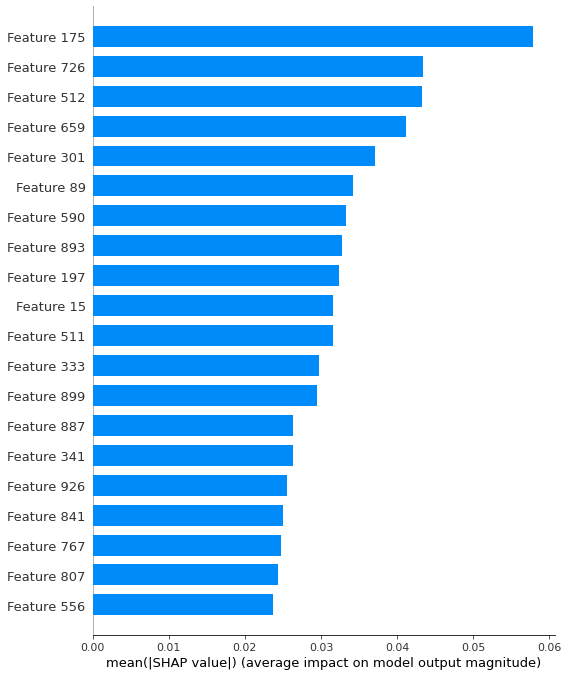

In [28]:
# Initialise the SHAP Kernel Explainer
explainer_svm = shap.KernelExplainer(svm.predict, X_train_sample)

# Compute Shapley values
shap_values_svm = explainer_svm.shap_values(X_sample)

# Assess whether certain bit appear more often than others
shap.summary_plot(shap_values_svm, X_sample, plot_type="bar")

  0%|          | 0/10 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

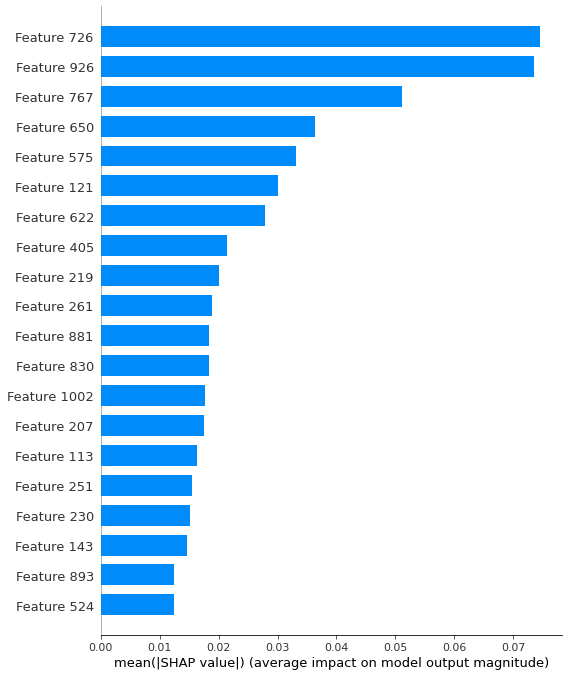

In [29]:
#Initialise the SHAP Kernel Explainer
explainer_dt = shap.KernelExplainer(dt.predict, X_train_sample)

# Compute Shapley values
shap_values_dt = explainer_dt.shap_values(X_sample)

# Assess whether certain bit appear more often than others
shap.summary_plot(shap_values_dt, X_sample, plot_type="bar")

  0%|          | 0/10 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

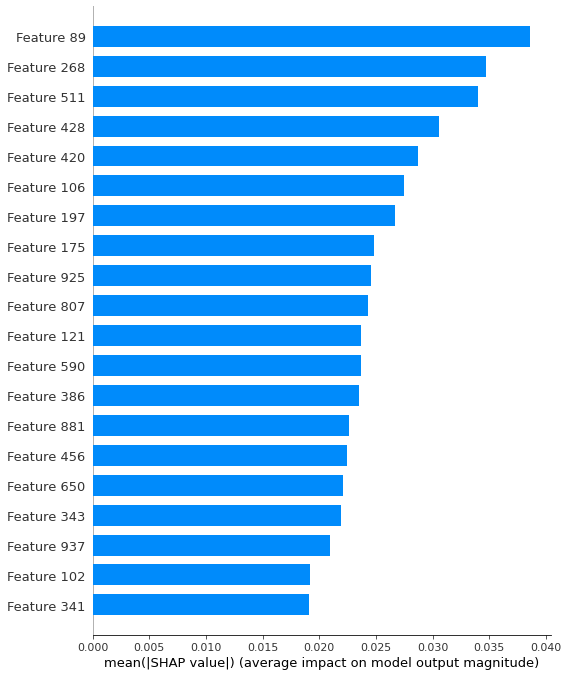

In [30]:
#Initialise the SHAP Kernel Explainer
explainer_nn = shap.KernelExplainer(nn.predict, X_train_sample)

# Compute Shapley values
shap_values_nn = explainer_nn.shap_values(X_sample)

# Assess whether certain bit appear more often than others
shap.summary_plot(shap_values_nn, X_sample, plot_type="bar")

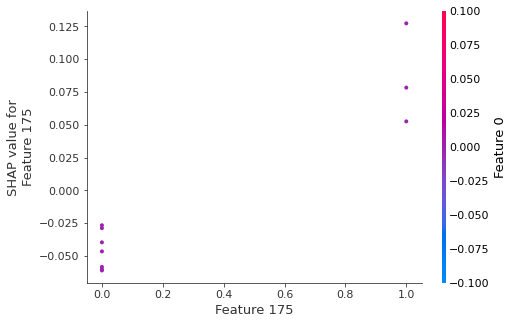

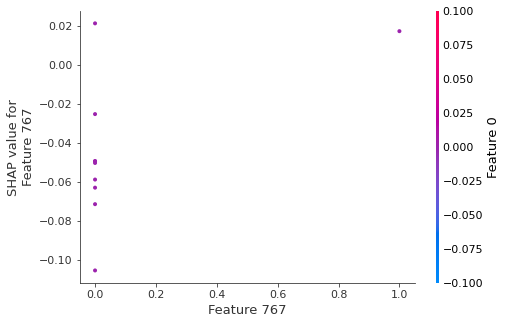

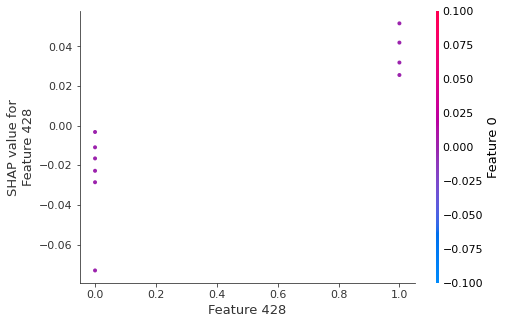

In [37]:
# Compare the Shapley values for thhe three models
shap.dependence_plot("rank(0)", shap_values_svm, X_sample)
shap.dependence_plot("rank(2)", shap_values_dt, X_sample)
shap.dependence_plot("rank(3)", shap_values_nn, X_sample)
#Plots the value of the feature on the x-axis and the SHAP value of the same feature on the y-axis. This shows how the model depends on the given feature, and is like a richer extenstion of the classical parital dependence plots. Vertical dispersion of the data points represents interaction effects.

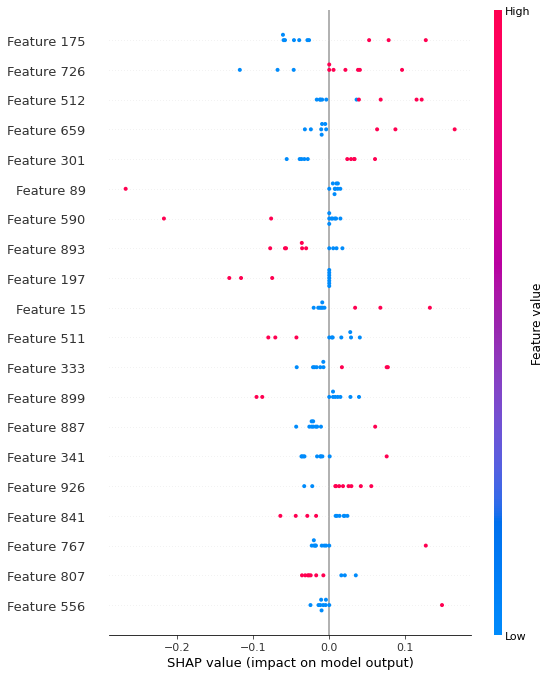

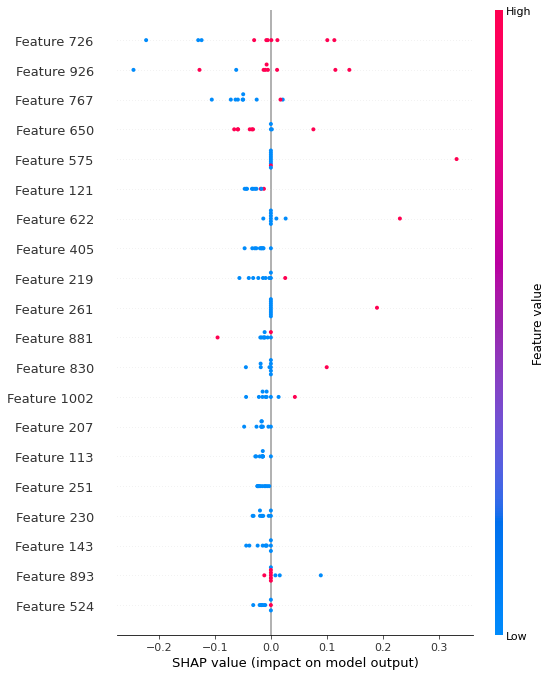

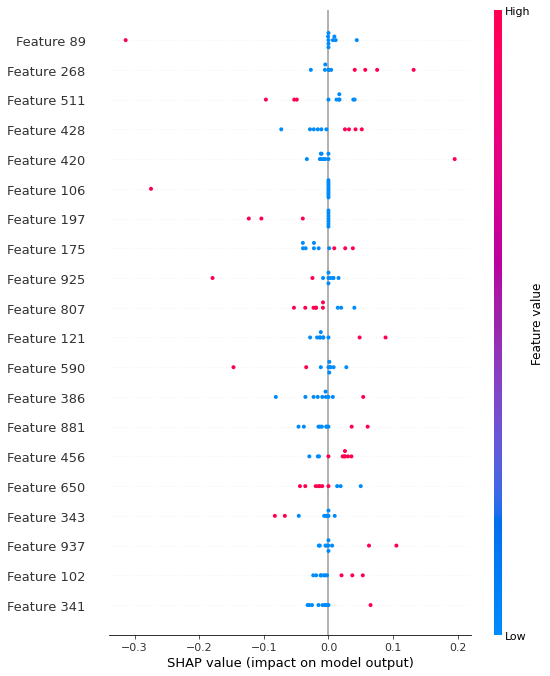

In [38]:
#Visualize the Shapley values for each molecule
shap.summary_plot(shap_values_svm, X_sample)
shap.summary_plot(shap_values_dt, X_sample)
shap.summary_plot(shap_values_nn, X_sample)

In [40]:
# 89 268 511
shap_values_nn

array([[ 0.        ,  0.        ,  0.        , -0.00590458,  0.01671811,
         0.        ,  0.        ,  0.        , -0.01097982, -0.01040987,
        ...,  0.        ,  0.        , -0.00716605, -0.00779485,
         0.        ,  0.00764782,  0.00033345,  0.        ,  0.        ,
         0.        ],
       [ 0.        , -0.0038591 ,  0.        , -0.00754497, -0.00974555,
         0.01233516,  0.        ,  0.        , -0.0154482 , -0.00649052,
        ...,  0.        ,  0.        ,  0.02023444, -0.00315408,
         0.        , -0.02336894,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.00970323,  0.        ,
        ...,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.0224165 ,  0.        ,
         

In [78]:
X_sample_copy = X_sample_n
X_sample_copy = X_sample_copy.append(X_sample_p)

In [79]:
X_sample_copy

1980    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4770    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
2141    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5069    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4150    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5366    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1450    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4093    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6062    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
322     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: fingerprints, dtype: object

In [80]:
X_sample_copy[4150]

In [90]:
Draw.DrawMorganBit(Chem.MolFromSmiles(df["smiles"][4]), 341, bi2)

TypeError: ignored

In [85]:
df["fingerprints"][4150]

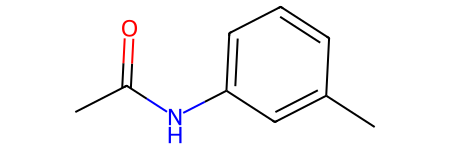

In [83]:
df["mols"][4150]

In [84]:
df["smiles"][4150]

'CC(=O)Nc1cccc(C)c1'